<a href="https://colab.research.google.com/github/iamdsc/humor_detection/blob/master/humor_detection_with_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Humor Detection with Deep Learning using Keras

In [0]:
# required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense,Dropout,SimpleRNN,LSTM,Conv1D,MaxPooling1D,GlobalMaxPooling1D,GRU
from keras.optimizers import RMSprop
from keras import backend as K

## Getting the data

In [2]:
# Load in the dataset
!git clone https://github.com/iamdsc/humor_detection.git

Cloning into 'humor_detection'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 25 (delta 6), reused 8 (delta 2), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [3]:
%cd humor_detection/datasets
!ls

/content/humor_detection/datasets
humorous_oneliners.pickle      proverbs.pickle		 wiki_sentences.pickle
oneliners_incl_doubles.pickle  reuters_headlines.pickle


In [0]:
# Read in the lists of sentences from respective pickle files
humour = pd.read_pickle('humorous_oneliners.pickle')
proverb = pd.read_pickle('proverbs.pickle')
wiki = pd.read_pickle('wiki_sentences.pickle')
long_humour = pd.read_pickle('oneliners_incl_doubles.pickle')
reuters = pd.read_pickle('reuters_headlines.pickle')

## Pre-processing the dataset

In [5]:
texts = []
labels = []

# shuffling the different negative samples
neg = proverb+wiki+reuters
np.random.shuffle(neg)

# adding the positive samples
print('No. of positive samples',len(humour))
for line in humour:
  texts.append(line)
  labels.append(1)
  
# taking equal samples from both classes
neg = neg[:len(humour)]

# adding the negative samples
print('No. of negative samples',len(neg))
for line in neg:
  texts.append(line)
  labels.append(0)
  
print('Total no. of samples',len(texts))

No. of positive samples 5251
No. of negative samples 5251
Total no. of samples 10502


In [6]:
# Tokenizing the data
maxlen = 50 # cut off sentences after 50 words
max_words = 10000 # only consider top 10000 common words in dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens'%len(word_index))

# padding the sequences
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.array(labels)

print('Shape of data tensor:',data.shape)
print('Shape of labels tensor:',labels.shape)

# shuffle the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Using TensorFlow backend.


Found 17012 unique tokens
Shape of data tensor: (10502, 50)
Shape of labels tensor: (10502,)


## Loading the pre-trained word embeddings

In [7]:
# due to small size of dataset
# we would use standford's GloVe pre-trained word embeddings

# download the GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-04-13 13:30:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-04-13 13:30:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  18.7MB/s    in 47s     

2019-04-13 13:31:10 (17.6 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [8]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [9]:
# parsing the GloVe word-embeddings file
embeddings_index = {}

f = open('glove.6B.100d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors:'%len(embeddings_index))

Found 400000 word vectors:


In [0]:
# preparing glove word embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i<max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector # for words not in embedding index values will be zeros

## Building the model

### 1. Simple feed-forward network with dense layers on top of embedding layer 

In [11]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                320064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,320,129
Trainable params: 1,320,129
Non-trainable params: 0
___________

In [0]:
# load pre-trained word embeddings into the embedding layer and freeze it
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [0]:
# to compute fmeasure as custom metric
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 2s 226us/step - loss: 0.3816 - acc: 0.8422 - f1: 0.8354 - val_loss: 0.2451 - val_acc: 0.9201 - val_f1: 0.9183
Epoch 2/20
9451/9451 [==============================] - 1s 138us/step - loss: 0.2671 - acc: 0.8939 - f1: 0.8884 - val_loss: 0.2182 - val_acc: 0.9267 - val_f1: 0.9236
Epoch 3/20
9451/9451 [==============================] - 1s 152us/step - loss: 0.2366 - acc: 0.9071 - f1: 0.9032 - val_loss: 0.2113 - val_acc: 0.9239 - val_f1: 0.9190
Epoch 4/20
9451/9451 [==============================] - 1s 149us/step - loss: 0.2189 - acc: 0.9122 - f1: 0.9089 - val_loss: 0.2094 - val_acc: 0.9210 - val_f1: 0.9187
Epoch 5/20
9451/9451 [==============================] - 1s 154us/step - loss: 0.2027 - acc: 0.9216 - f1: 0.9188 - val_loss: 0.1952 - val_acc: 0.9277 - val_f1: 0.9237
Epoch 6/20
9451/9451 [==============================] - 1s 151us/step - lo

In [0]:
# helper function to plot the results
def plot_result(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  f1 = history.history['f1']
  val_f1 = history.history['val_f1']
  
  epochs = range(1, len(acc)+1)

  plt.plot(epochs, acc, label='Training acc')
  plt.plot(epochs, val_acc, label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('acc')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()

  plt.figure()

  plt.plot(epochs, f1, label='Training fmeasure')
  plt.plot(epochs, val_f1, label='Validation fmeasure')
  plt.title('Training and validation fmeasure')
  plt.xlabel('epochs')
  plt.ylabel('f1')
  plt.legend()
  
  plt.show()

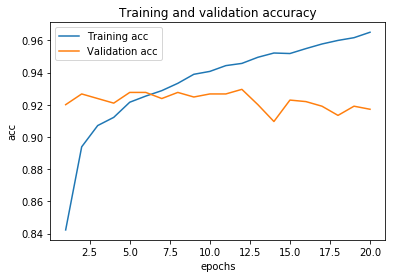

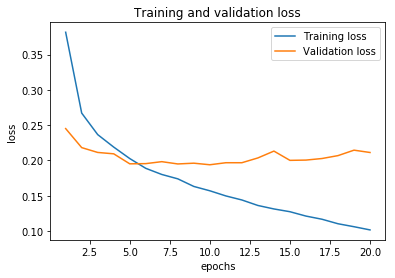

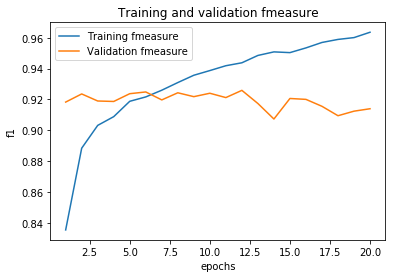

In [16]:
# plotting the results
plot_result(history)

In [17]:
# Building model without pre-trained word embeddings

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                320064    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,320,129
Trainable params: 1,320,129
Non-trainable params: 0
_________________________________________________________________
Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 2s 215us/step - loss: 0.6241

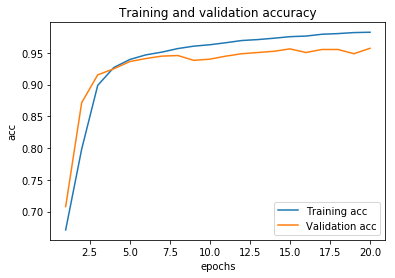

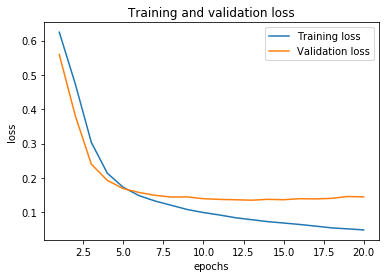

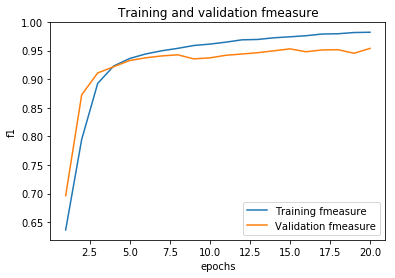

In [18]:
plot_result(history)

### 2. Using Simple RNN layer on top of embedding layer

In [19]:
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(SimpleRNN(64, dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                6208      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 326,273
Trainable params: 326,273
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data,labels, epochs=20, batch_size=32, validation_split=0.1)

Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 9s 916us/step - loss: 0.6248 - acc: 0.6642 - f1: 0.6469 - val_loss: 0.5682 - val_acc: 0.7127 - val_f1: 0.7169
Epoch 2/20
9451/9451 [==============================] - 8s 856us/step - loss: 0.4729 - acc: 0.7952 - f1: 0.7787 - val_loss: 0.3327 - val_acc: 0.8820 - val_f1: 0.8708
Epoch 3/20
9451/9451 [==============================] - 8s 853us/step - loss: 0.3095 - acc: 0.8801 - f1: 0.8704 - val_loss: 0.2434 - val_acc: 0.9077 - val_f1: 0.9001
Epoch 4/20
9451/9451 [==============================] - 8s 853us/step - loss: 0.2435 - acc: 0.9081 - f1: 0.9016 - val_loss: 0.2151 - val_acc: 0.9220 - val_f1: 0.9162
Epoch 5/20
9451/9451 [==============================] - 8s 857us/step - loss: 0.2074 - acc: 0.9219 - f1: 0.9164 - val_loss: 0.4029 - val_acc: 0.8097 - val_f1: 0.8346
Epoch 6/20
9451/9451 [==============================] - 8s 857us/step - loss: 0.1860 - acc: 0.9302 - f1: 0.9263 - val_loss

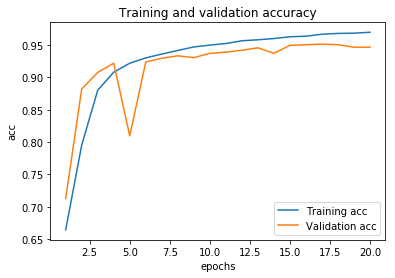

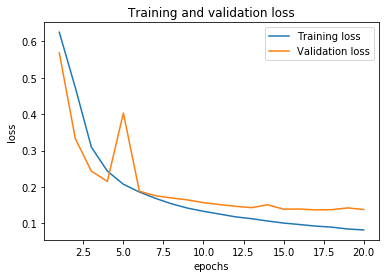

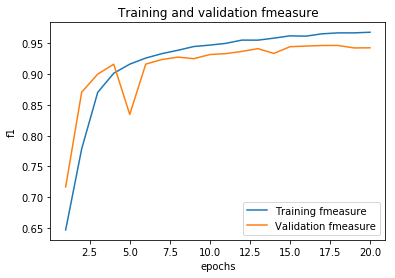

In [21]:
plot_result(history)

### 3. Using LSTM layer on top of the embedding layer

In [22]:
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 33s 3ms/step - loss: 0.6823 - acc: 0.6671 - f1: 0.6139 - val_loss: 0.6620 - val_acc: 0.7821 - val_f1: 0.7533
Epoch 2/20
9451/9451 [==============================] - 32s 3ms/step - loss: 0.6236 - acc: 0.7736 - f1: 0.7528 - val_loss: 0.5588 - val_acc: 0.8430 - val_f1: 0.8400
Epoch 3/20
9451/9451 [==============================] - 31s 3ms/step - loss: 0.5002 - acc: 0.8219 - f1: 0.8175 - val_loss: 0.3996 - val_acc: 0.8839 - val_f1: 0.8844
Epoch 4/20
9451/9451 [==============================] - 30s 3ms/step - loss: 0.3605 - acc: 0.8729 - f1: 0.8683 - val_loss: 0.2718 - val_acc: 0.9077 - val_f1: 0.9042
Epoch 5/20
9451/9451 [==============================] - 31s 3ms/step - loss: 0.2683 - acc: 0.9085 - f1: 0.9049 - val_loss: 0.2148 - val_acc: 0.9134 - val_f1: 0.9108
Epoch 6/20
9451/9451 [==============================] - 31s 3ms/step - loss: 0.2262 - acc: 0.9176 - f1: 0.9147 - val_loss: 0.19

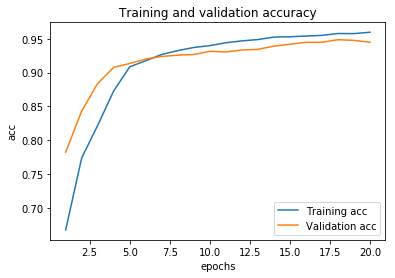

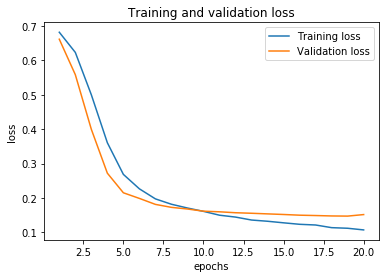

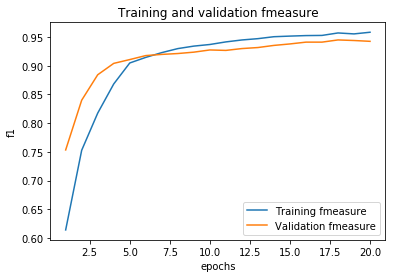

In [24]:
plot_result(history)

### 3. Using two Conv1D layers on top of the Embedding layer

In [25]:
model = Sequential()
model.add(Embedding(max_words, 32))

model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(5))

model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          10304     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 335,521
Trainable params: 335,521
Non-trainable params: 0
_________________________________________________________________


In [26]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 5s 494us/step - loss: 0.6799 - acc: 0.5616 - f1: 0.6843 - val_loss: 0.6601 - val_acc: 0.6889 - val_f1: 0.7343
Epoch 2/20
9451/9451 [==============================] - 2s 210us/step - loss: 0.6038 - acc: 0.7529 - f1: 0.7752 - val_loss: 0.5286 - val_acc: 0.8059 - val_f1: 0.8135
Epoch 3/20
9451/9451 [==============================] - 2s 211us/step - loss: 0.4255 - acc: 0.8572 - f1: 0.8520 - val_loss: 0.3308 - val_acc: 0.8830 - val_f1: 0.8746
Epoch 4/20
9451/9451 [==============================] - 2s 211us/step - loss: 0.2859 - acc: 0.8980 - f1: 0.8907 - val_loss: 0.2546 - val_acc: 0.9058 - val_f1: 0.8990
Epoch 5/20
9451/9451 [==============================] - 2s 210us/step - loss: 0.2351 - acc: 0.9129 - f1: 0.9070 - val_loss: 0.2254 - val_acc: 0.9191 - val_f1: 0.9120
Epoch 6/20
9451/9451 [======================

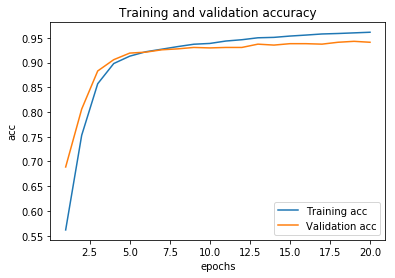

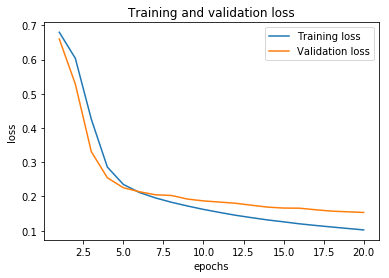

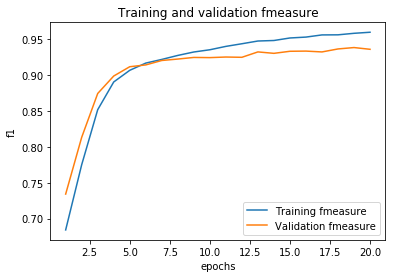

In [27]:
# plot the results
plot_result(history)

### 4. Using LSTM layer on top of Conv1D layer

In [28]:
model = Sequential()
model.add(Embedding(max_words, 32))

model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(5))

model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 350,049
Trainable params: 350,049
Non-trainable params: 0
_________________________________________________________________


In [29]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 9s 938us/step - loss: 0.6842 - acc: 0.6721 - f1: 0.6929 - val_loss: 0.6655 - val_acc: 0.7593 - val_f1: 0.7774
Epoch 2/20
9451/9451 [==============================] - 8s 812us/step - loss: 0.5961 - acc: 0.7978 - f1: 0.7936 - val_loss: 0.4896 - val_acc: 0.8468 - val_f1: 0.8387
Epoch 3/20
9451/9451 [==============================] - 8s 821us/step - loss: 0.4027 - acc: 0.8565 - f1: 0.8454 - val_loss: 0.3118 - val_acc: 0.8858 - val_f1: 0.8752
Epoch 4/20
9451/9451 [==============================] - 8s 826us/step - loss: 0.2879 - acc: 0.8927 - f1: 0.8851 - val_loss: 0.2494 - val_acc: 0.9125 - val_f1: 0.9055
Epoch 5/20
9451/9451 [==============================] - 8s 812us/step - loss: 0.2404 - acc: 0.9122 - f1: 0.9067 - val_loss: 0.2192 - val_acc: 0.9191 - val_f1: 0.9116
Epoch 6/20
9451/9451 [==============================] - 8s 811us/step - loss: 0.2120 - acc: 0.9219 - f1: 0.9167 - val_loss

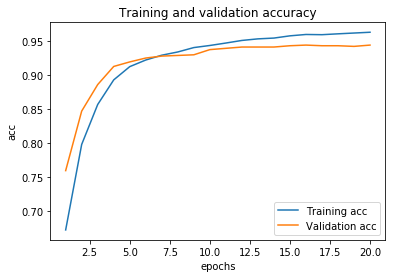

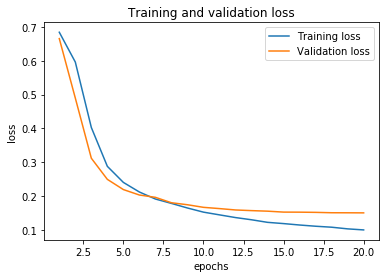

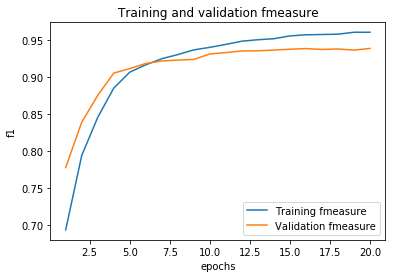

In [30]:
# plot the results
plot_result(history)

### 5. Using GRU layer on top of Conv1D layer

In [32]:
model = Sequential()
model.add(Embedding(max_words, 32))

model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(5))

model.add(GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 343,841
Trainable params: 343,841
Non-trainable params: 0
_________________________________________________________________


In [33]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 8s 820us/step - loss: 0.6875 - acc: 0.6205 - f1: 0.4911 - val_loss: 0.6765 - val_acc: 0.6765 - val_f1: 0.5688
Epoch 2/20
9451/9451 [==============================] - 6s 679us/step - loss: 0.6452 - acc: 0.7321 - f1: 0.6884 - val_loss: 0.5878 - val_acc: 0.8002 - val_f1: 0.7836
Epoch 3/20
9451/9451 [==============================] - 6s 677us/step - loss: 0.4977 - acc: 0.8214 - f1: 0.8111 - val_loss: 0.3742 - val_acc: 0.8696 - val_f1: 0.8617
Epoch 4/20
9451/9451 [==============================] - 6s 676us/step - loss: 0.3306 - acc: 0.8766 - f1: 0.8711 - val_loss: 0.2622 - val_acc: 0.9068 - val_f1: 0.9007
Epoch 5/20
9451/9451 [==============================] - 6s 679us/step - loss: 0.2624 - acc: 0.9064 - f1: 0.9008 - val_loss: 0.2218 - val_acc: 0.9153 - val_f1: 0.9105
Epoch 6/20
9451/9451 [==============================] - 6s 678us/step - loss: 0.2283 - acc: 0.9214 - f1: 0.9173 - val_loss

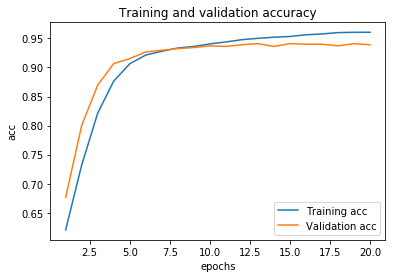

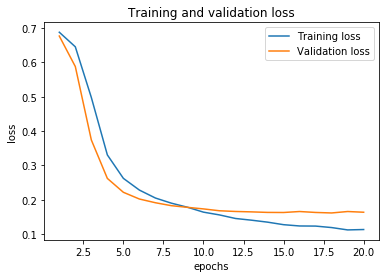

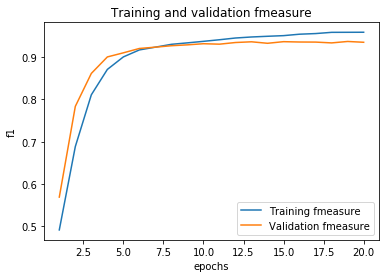

In [34]:
# plot the results
plot_result(history)

### 6. Using two GRU layers on top of two Conv1D layers

In [36]:
model = Sequential()
model.add(Embedding(max_words, 32))

model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(5))

model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(5))

model.add(GRU(32, activation='relu', dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
model.add(GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 64)          10304     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, None, 32)          9312      
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                18624     
__________

In [37]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 6s 655us/step - loss: 0.6901 - acc: 0.6507 - f1: 0.6732 - val_loss: 0.6820 - val_acc: 0.7203 - val_f1: 0.7410
Epoch 2/20
9451/9451 [==============================] - 4s 423us/step - loss: 0.6324 - acc: 0.7595 - f1: 0.7736 - val_loss: 0.5265 - val_acc: 0.7897 - val_f1: 0.8004
Epoch 3/20
9451/9451 [==============================] - 4s 419us/step - loss: 0.3864 - acc: 0.8559 - f1: 0.8500 - val_loss: 0.2784 - val_acc: 0.8934 - val_f1: 0.8888
Epoch 4/20
9451/9451 [==============================] - 4s 423us/step - loss: 0.2703 - acc: 0.8997 - f1: 0.8932 - val_loss: 0.2316 - val_acc: 0.9191 - val_f1: 0.9115
Epoch 5/20
9451/9451 [==============================] - 4s 420us/step - loss: 0.2376 - acc: 0.9111 - f1: 0.9045 - val_loss: 0.2197 - val_acc: 0.9239 - val_f1: 0.9172
Epoch 6/20
9451/9451 [==============================] - 4s 422us/step - loss: 0.2102 - acc: 0.9223 - f1: 0.9172 - val_loss

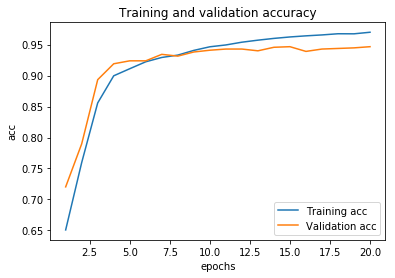

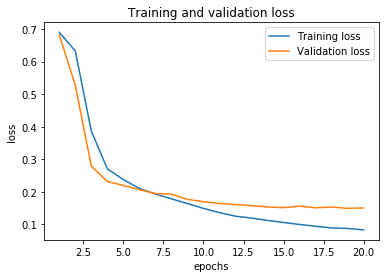

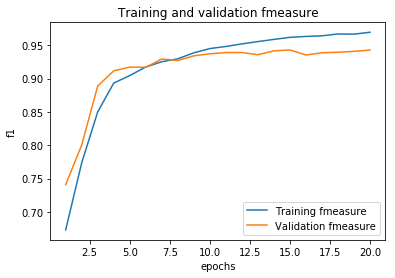

In [38]:
# plot the results
plot_result(history)